importamos las librerias que necesitamos utilizar

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_variable", 0: "n_variables"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        )

    def missing_case_table(self) -> pd.DataFrame():
        return (
            self._obj.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_case", 0: "n_cases"})
            .assign(pct_case=lambda df: df.n_cases / df.n_cases.sum() * 100)
            .sort_values("pct_case", ascending=False)
        )

    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._obj.assign(
                span_counter=lambda df: (
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
            )
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )

    def sort_variables_by_missingness(self, ascending = False):

        return (
            self._obj
            .pipe(
                lambda df: (
                    df[df.isna().sum().sort_values(ascending = ascending).index]
                )
            )
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
        suffix: str = "_NA",
    ) -> pd.DataFrame:
        return (
            self._obj.isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix(suffix)
        )

    def bind_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
        suffix: str = "_NA",
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing,
                    suffix=suffix,
                ),
            ],
            axis="columns",
        )

    def missing_scan_count(self, search) -> pd.DataFrame:
        return (
            self._obj.apply(axis="rows", func=lambda column: column.isin(search))
            .sum()
            .reset_index()
            .rename(columns={"index": "variable", 0: "n"})
            .assign(original_type=self._obj.dtypes.reset_index()[0])
        )

    # Plotting functions ---

    def missing_variable_plot(self):
        df = self._obj.missing.missing_variable_summary().sort_values("n_missing")

        plot_range = range(1, len(df.index) + 1)

        plt.hlines(y=plot_range, xmin=0, xmax=df.n_missing, color="black")

        plt.plot(df.n_missing, plot_range, "o", color="black")

        plt.yticks(plot_range, df.variable)

        plt.grid(axis="y")

        plt.xlabel("Number missing")
        plt.ylabel("Variable")

    def missing_case_plot(self):

        df = self._obj.missing.missing_case_summary()

        sns.displot(data=df, x="n_missing", binwidth=1, color="black")

        plt.grid(axis="x")
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")

    def missing_variable_span_plot(
        self, variable: str, span_every: int, rot: int = 0, figsize=None
    ):

        (
            self._obj.missing.missing_variable_span(
                variable=variable, span_every=span_every
            ).plot.bar(
                x="span_counter",
                y=["pct_missing", "pct_complete"],
                stacked=True,
                width=1,
                color=["black", "lightgray"],
                rot=rot,
                figsize=figsize,
            )
        )

        plt.xlabel("Span number")
        plt.ylabel("Percentage missing")
        plt.legend(["Missing", "Present"])
        plt.title(
            f"Percentage of missing values\nOver a repeating span of { span_every } ",
            loc="left",
        )
        plt.grid(False)
        plt.margins(0)
        plt.tight_layout(pad=0)

    def missing_upsetplot(self, variables: list[str] = None, **kwargs):

        if variables is None:
            variables = self._obj.columns.tolist()

        return (
            self._obj.isna()
            .value_counts(variables)
            .pipe(lambda df: upsetplot.plot(df, **kwargs))
        )

    def scatter_imputation_plot(
        self, x, y, imputation_suffix="_imp", show_marginal=False, **kwargs
    ):

        x_imputed = f"{ x }{ imputation_suffix }"
        y_imputed = f"{ y }{ imputation_suffix }"

        plot_func = sns.scatterplot if not show_marginal else sns.jointplot

        return (
            self._obj[[x, y, x_imputed, y_imputed]]
            .assign(is_imputed=lambda df: df[x_imputed] | df[y_imputed])
            .pipe(lambda df: (plot_func(data=df, x=x, y=y, hue="is_imputed", **kwargs)))
        )

damos una vista rapida a nuestro data set

In [36]:
ventas1 = pd.read_csv('Advertising.csv')
ventas1.head(15)

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
5,6,8.7,48.9,75.0,7.2
6,7,57.5,32.8,23.5,11.8
7,8,120.2,19.6,11.6,13.2
8,9,8.6,2.1,1.0,4.8
9,10,199.8,2.6,21.2,10.6


observamos si tenemos datos faltantes y que porcentaje representan

In [37]:
ventas1.dtypes

Unnamed: 0      int64
TV            float64
Radio         float64
Newspaper     float64
Sales         float64
dtype: object

In [38]:
ventas1.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,Unnamed: 0,0,200,0.0
1,TV,0,200,0.0
2,Radio,0,200,0.0
3,Newspaper,0,200,0.0
4,Sales,0,200,0.0


<Axes: >

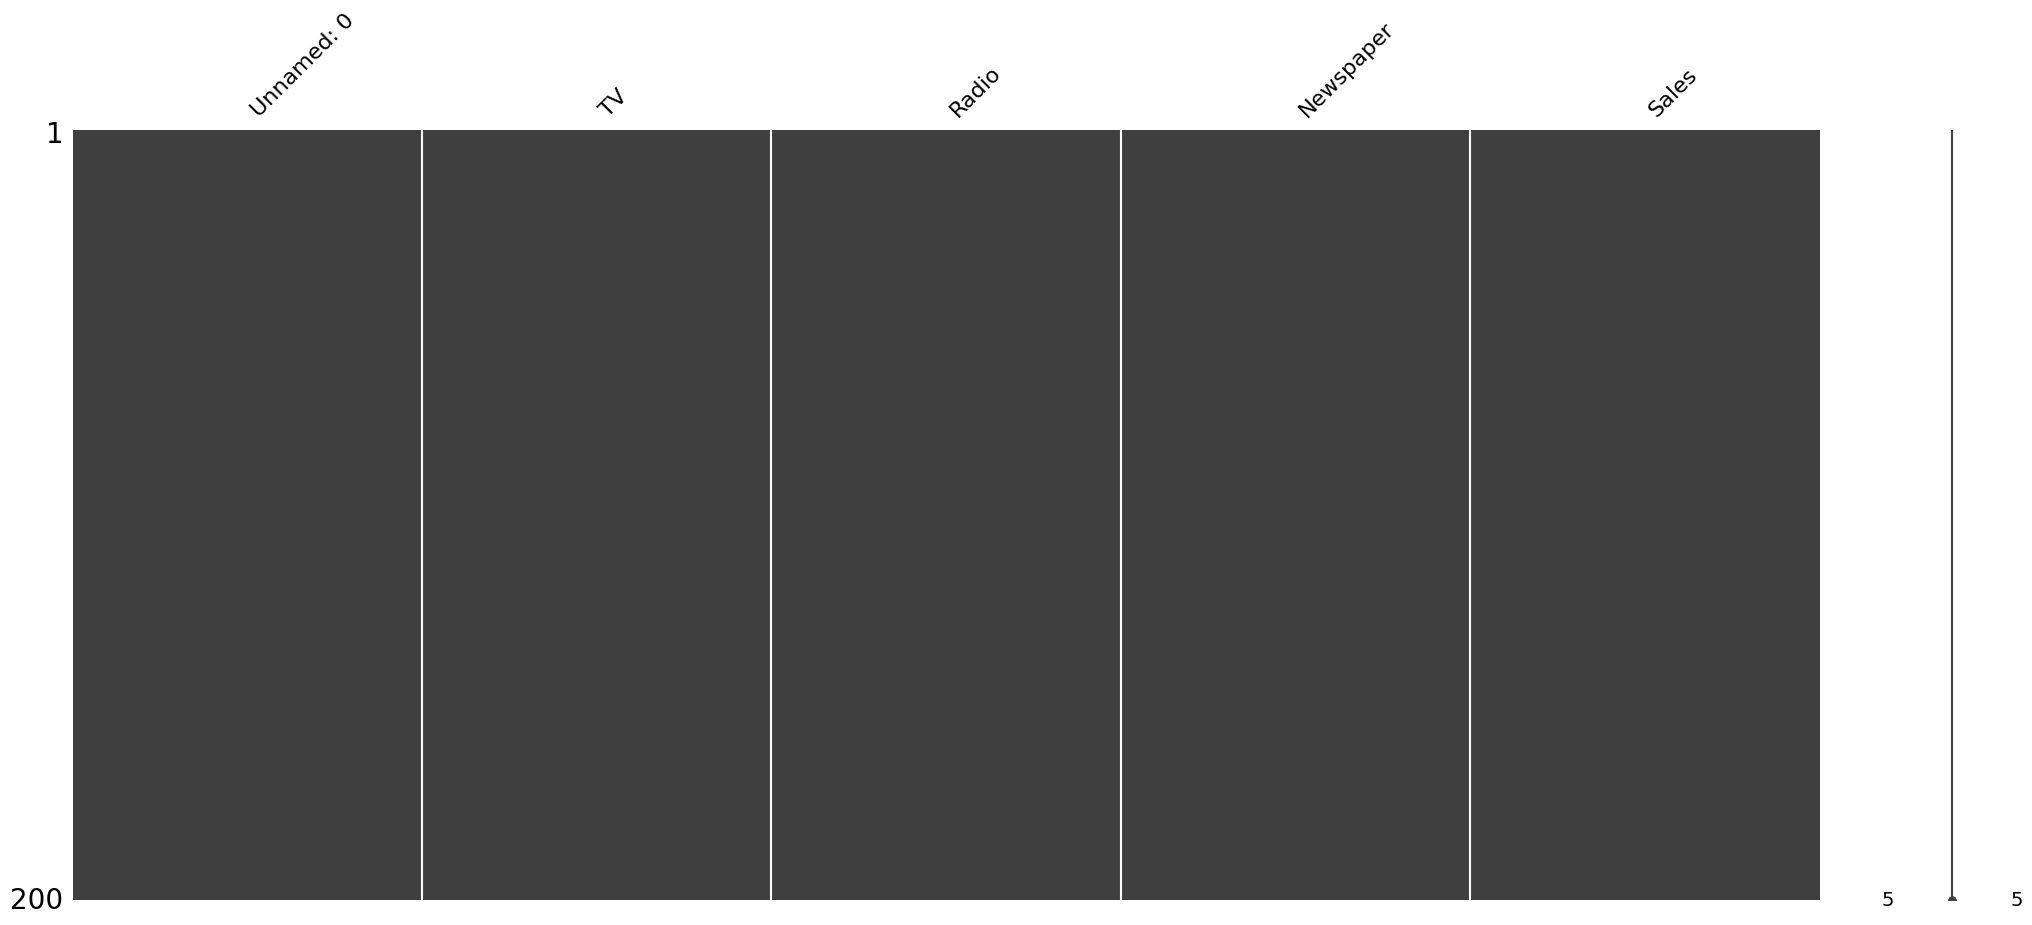

In [39]:
import missingno
missingno.matrix(df=ventas1)

como sabemos que las columnas son de tipo numerica buscamos ya que si hay algun dato de tipo object , podria ser un dato nulo

In [40]:
ventas1.select_dtypes(object).apply(pd.unique) # buscamos datos tipo object

Series([], dtype: float64)

In [41]:
ventas1.select_dtypes(float).apply(pd.unique)

TV           [230.1, 44.5, 17.2, 151.5, 180.8, 8.7, 57.5, 1...
Radio        [37.8, 39.3, 45.9, 41.3, 10.8, 48.9, 32.8, 19....
Newspaper    [69.2, 45.1, 69.3, 58.5, 58.4, 75.0, 23.5, 11....
Sales        [22.1, 10.4, 9.3, 18.5, 12.9, 7.2, 11.8, 13.2,...
dtype: object

calculemos el Roi por medio de comunicacion para ver como es el retorno de nuestra inversion

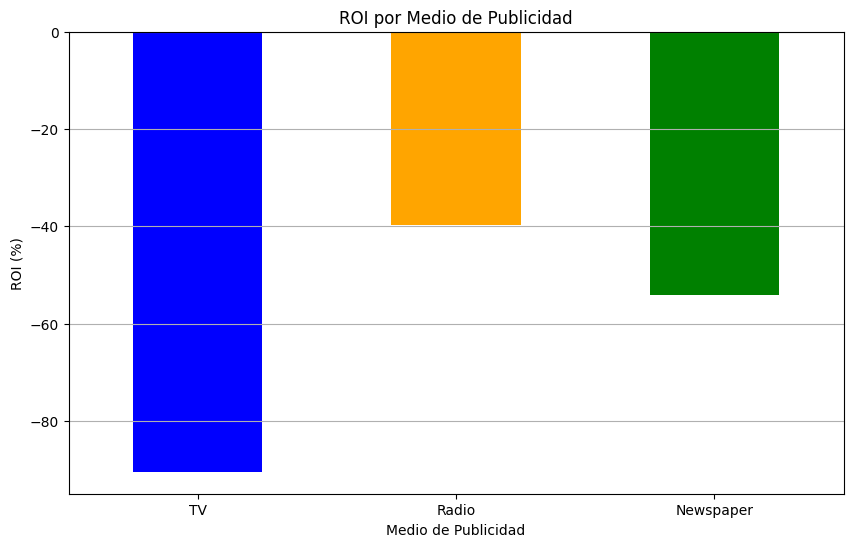

In [42]:
# Calcular el total de gastos y ventas
total_gastos = ventas1[['TV', 'Radio', 'Newspaper']].sum()
total_ventas = ventas1['Sales'].sum()

# Suponiendo que las ventas están directamente relacionadas con los gastos en publicidad,
# y considerando las ventas como el retorno, calculamos el ROI
roi = (total_ventas - total_gastos) / total_gastos * 100

# Crear una visualización
plt.figure(figsize=(10, 6))
roi.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('ROI por Medio de Publicidad')
plt.xlabel('Medio de Publicidad')
plt.ylabel('ROI (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

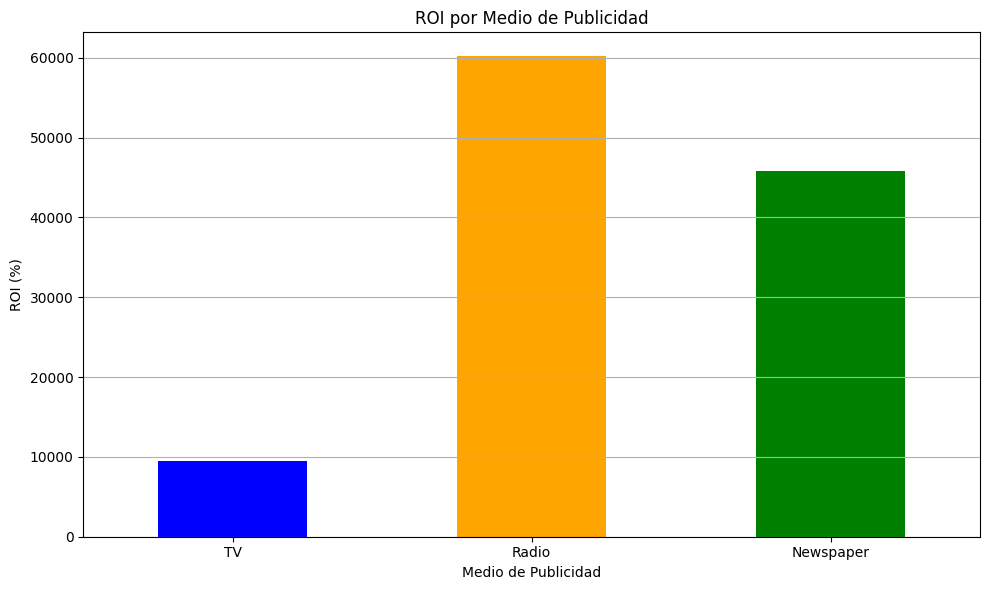

In [43]:
total_gastos = ventas1[['TV', 'Radio', 'Newspaper']].sum()
total_ventas = ventas1['Sales'].sum() * 1000  # Asumiendo que las ventas están en miles de unidades para ajustar a gastos

# Calculando el ROI
roi = (total_ventas - total_gastos) / total_gastos * 100

# Crear una visualización
plt.figure(figsize=(10, 6))
roi.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('ROI por Medio de Publicidad')
plt.xlabel('Medio de Publicidad')
plt.ylabel('ROI (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

como puntos resaltantes podemos  ver que el retorno sobre la inversion de ciertos medios es muy superior a otros , en este caso podemos ver que el medio radio puede ser muy superior al de tv , esto pudiera ser por que el publico objetivo es as facil de llegar por radio o por que los costos de la publicidad por este medio pueden ser mucho menores , hay que estudiar mas a profundidad esto pero dependiendo del resultado pudiera considerarse asignar un poco mas de presupuesto a este medio

utilizaremos un metodo de regresion lineal multiple para ver como se comportan las interacciones entre los medios con referente a las ventas , muchas veces la combinacion entre dos factores  tiene una relevancia mayor que cada una por separado

In [45]:
import statsmodels.api as sm

# Preparar los datos con términos de interacción
ventas1['TV_Radio'] = ventas1['TV'] * ventas1['Radio']
ventas1['TV_Newspaper'] = ventas1['TV'] * ventas1['Newspaper']
ventas1['Radio_Newspaper'] = ventas1['Radio'] * ventas1['Newspaper']

# Variables independientes con interacciones y variable dependiente
X = ventas1[['TV', 'Radio', 'Newspaper', 'TV_Radio', 'TV_Newspaper', 'Radio_Newspaper']]
y = ventas1['Sales']

# Añadir una constante al modelo
X = sm.add_constant(X)

# Construir y ajustar el modelo de regresión
model = sm.OLS(y, X).fit()

# Resumen del modelo
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     993.3
Date:                Thu, 04 Apr 2024   Prob (F-statistic):          3.68e-142
Time:                        02:56:31   Log-Likelihood:                -267.49
No. Observations:                 200   AIC:                             549.0
Df Residuals:                     193   BIC:                             572.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.4602      0.318     20.342      0.000       5.834       7.087
TV                  0.0203      0.002     12.633      0.000       0.017       0.024
Radio               0.0229      0.011      2.009      0.046       0.000       0.045
Newspaper           0.0170      0.010      1.691      0.092      -0.003       0.037
TV_Radio            0.0011   5.72e-05     19.930      0.000       0.001       0.001
TV_Newspaper    -7.971e-05   3.58e-05     -2.227      0.027      -0.000   -9.12e-06
Radio_Newspaper    -0.0001      0.000     -0.464      0.643      -0.001       0.000
==============================================================================
Omnibus:                      111.385   Durbin-Watson:                   2.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              767.483
Skew:                          -2.046   Prob(JB):                    2.20e-167
Kurtosis:                      11.681   Cond. No.                     3.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

TV_Radio tiene un coeficiente de 0.0011 con un valor p muy bajo (p < 0.0001), indicando una alta significancia estadística.Esto sugiere que hay una sinergia significativa entre los gastos en publicidad en TV y radio. La combinación de estos medios es más efectiva en impulsar las ventas que lo que sugerirían sus efectos individuales

Aunque la interacción entre TV y periódicos es significativa, el signo negativo sugiere un efecto antagónico. Esto podría indicar que, hasta cierto punto, los gastos en publicidad en TV y periódicos pueden estar compitiendo entre sí en términos de efectividad

In [47]:
import numpy as np

tv_33, tv_66 = np.percentile(ventas1['TV'], [33, 66])
radio_33, radio_66 = np.percentile(ventas1['Radio'], [33, 66])
newspaper_33, newspaper_66 = np.percentile(ventas1['Newspaper'], [33, 66])

# Función para categorizar los gastos
def categorize_spending(x, p33, p66):
    if x <= p33:
        return 'Bajo'
    elif p33 < x <= p66:
        return 'Medio'
    else:
        return 'Alto'

# Aplicar la categorización
ventas1['TV_Level'] = ventas1['TV'].apply(categorize_spending, args=(tv_33, tv_66))
ventas1['Radio_Level'] = ventas1['Radio'].apply(categorize_spending, args=(radio_33, radio_66))
ventas1['Newspaper_Level'] = ventas1['Newspaper'].apply(categorize_spending, args=(newspaper_33, newspaper_66))

# Análisis de ventas promedio por nivel de gasto
sales_by_tv_level = ventas.groupby('TV_Level')['Sales'].mean()
sales_by_radio_level = ventas.groupby('Radio_Level')['Sales'].mean()
sales_by_newspaper_level = ventas.groupby('Newspaper_Level')['Sales'].mean()

print(sales_by_tv_level)
print(sales_by_radio_level)
print(sales_by_newspaper_level)

TV_Level
Alto     18.394030
Bajo      9.177273
Medio    14.423881
Name: Sales, dtype: float64
Radio_Level
Alto     17.429412
Bajo     10.568182
Medio    13.966667
Name: Sales, dtype: float64
Newspaper_Level
Alto     16.179412
Bajo     13.245455
Medio    12.577273
Name: Sales, dtype: float64


Efectividad Pronunciada del Gasto en TV:

El salto en las ventas promedio de bajo (9.18) a medio (14.42) y de medio a alto (18.39) en el gasto de TV demuestra una relación fuertemente positiva. Esto indica que el gasto en publicidad en TV tiene un retorno significativo en términos de incremento en ventas, lo que sugiere una alta efectividad de este medio para alcanzar a la audiencia y promover compras.
Incremento Consistente en Ventas con el Gasto en Radio:

Similar a la TV, el gasto en Radio muestra un incremento constante en las ventas promedio al moverse de bajo (10.57) a medio (13.97) y a alto (17.43). Esto refleja que la radio, como medio publicitario, también es efectiva en generar ventas, aunque el incremento no es tan pronunciado como en TV.

Los resultados para el periódico muestran un patrón menos claro. Mientras que el segmento de alto gasto tiene ventas promedio mayores (16.18) comparado con el medio (12.58), el segmento de bajo gasto (13.25) supera al medio. Esto podría sugerir que existe un punto de disminución de retornos para el gasto en publicidad en periódicos, donde aumentos adicionales en gasto no necesariamente se traducen en un aumento proporcional de ventas.

Entrenmos un modelo de random forest para predecir ventas dependiendo de ajustes en los gastos de publicidad


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = ventas1[['TV', 'Radio', 'Newspaper']]
y = ventas1['Sales']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bosque= RandomForestRegressor()
bosque.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

entrenamos un modelo en rejilla para ver los mejores parametros

In [14]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [25, 50, 100],
    'max_leaf_nodes': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.75, 1.0],
    'max_depth': [ 10, 20, 30, 40],
    'criterion': ['squared_error']  # Diferentes criterios para medir la calidad de una división
}

# Creamos el modelo de Bosque Aleatorio
bosque = RandomForestRegressor(random_state=42)

# Creamos el objeto GridSearchCV
grid_search = GridSearchCV(estimator=bosque, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

In [15]:
grid_search.fit(X_train, y_train)

# Mejores parámetros y mejor puntuación
print(f'Mejores parámetros: {grid_search.best_params_}')
print(f'Mejor puntuación (RMSE): {np.sqrt(-grid_search.best_score_)}')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Mejores parámetros: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 100}
Mejor puntuación (RMSE): 0.8286693701350373


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [16]:
predictions = grid_search.best_estimator_.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE en el conjunto de prueba: {rmse_test}')

RMSE en el conjunto de prueba: 0.7685910811348248


In [ ]:
pip install joblib


In [ ]:
from sklearn.model_selection import GridSearchCV
import joblib
joblib.dump(grid_search.best_estimator_, 'mejor_modelo_entrenado.pkl')

In [17]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print(importance_df)


     Feature  Importance
0         TV    0.624810
1      Radio    0.362201
2  Newspaper    0.012989


con este modelo podemos confirmar que una de las caracteristicas mas importantes en cuanto a las ventas es el gasto que se hace en

ahora planteamos escenarios en donde modificamos los montos que la empresa invierte en publicidad

# escenario 1 : se sube un 20% el gasto en radio y se disminuye un 10% en TV y Newspaper

In [18]:
gasto_base = X_test.mean().values.reshape(1, -1)

# Definir escenarios de cambio en el gasto
# Aumento del 20% en Radio, reducción del 10% en TV y Periódico
gasto_escenario = gasto_base * np.array([[0.9, 1.2, 0.9]])

# Predecir ventas para el escenario base
ventas_base = grid_search.best_estimator_.predict(gasto_base)

# Predecir ventas para el escenario modificado
ventas_escenario = grid_search.best_estimator_.predict(gasto_escenario)

# Mostrar los resultados
print(f"Ventas predichas con gasto base: {ventas_base[0]}")
print(f"Ventas predichas con el escenario modificado: {ventas_escenario[0]}")

# Calcular el cambio porcentual en las ventas
cambio_ventas = ((ventas_escenario - ventas_base) / ventas_base) * 100
print(f"Cambio porcentual en las ventas: {cambio_ventas[0]}%")

Ventas predichas con gasto base: 14.449000000000012
Ventas predichas con el escenario modificado: 14.561000000000014
Cambio porcentual en las ventas: 0.7751401481071477%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


podemos ver que hay una sensibilidad en las ventas , en donde se sube un porcentaje en Radio y rapidamente hay una movida en el total de ventas

# Escenario 2: reducimos el gasto en Newspaper a 5% y el otro 95% lo redistribuimos en Tv y Radio

In [19]:
gasto_total_base = gasto_base.sum(axis=1).reshape(-1, 1)

# Calculamos nuevo gasto en Newspaper para que sea el 5% del total correctamente
newspaper_nuevo_gasto = (gasto_total_base * 0.05)


# Distribuimos el 95% restante entre TV y Radio basado en su proporción actual del gasto total excluyendo Newspaper
tv_radio_proporcion_actual = gasto_base[:, :2] / gasto_base[:, :2].sum(axis=1, keepdims=True)
gasto_restante = gasto_total_base * 0.95
nuevo_gasto_tv_radio = gasto_restante * tv_radio_proporcion_actual


gasto_escenario_ajustado = np.hstack((nuevo_gasto_tv_radio, newspaper_nuevo_gasto))

# Predecimos ventas para el escenario base y ajustado como antes
ventas_base = grid_search.best_estimator_.predict(gasto_base)
ventas_escenario_ajustado = grid_search.best_estimator_.predict(gasto_escenario_ajustado)


print(f"Ventas predichas con gasto base: {ventas_base[0]}")
print(f"Ventas predichas con el escenario ajustado: {ventas_escenario_ajustado[0]}")
cambio_ventas_ajustado = ((ventas_escenario_ajustado - ventas_base) / ventas_base) * 100
print(f"Cambio porcentual en las ventas con el escenario ajustado: {cambio_ventas_ajustado[0]}%")

Ventas predichas con gasto base: 14.449000000000012
Ventas predichas con el escenario ajustado: 16.466999999999985
Cambio porcentual en las ventas con el escenario ajustado: 13.96636445428729%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


podemos ver que al subir los gastos en tv significativamente las ventas tienden a tener una subida un poco mas pronunciada

In [20]:
gasto_total_ajustado = nuevo_gasto_tv_radio.sum() + newspaper_nuevo_gasto

# Porcentajes de gasto ajustado para TV y Radio
# No es necesario calcular el porcentaje de Newspaper ya que lo hemos fijado explícitamente al 5%
porcentaje_tv_ajustado = (nuevo_gasto_tv_radio[:, 0] / gasto_total_ajustado) * 100
porcentaje_radio_ajustado = (nuevo_gasto_tv_radio[:, 1] / gasto_total_ajustado) * 100

print(f"Porcentaje del gasto ajustado en TV: {porcentaje_tv_ajustado[0]}%")
print(f"Porcentaje del gasto ajustado en Radio: {porcentaje_radio_ajustado[0]}%")


Porcentaje del gasto ajustado en TV: [80.26023351]%
Porcentaje del gasto ajustado en Radio: [14.73976649]%


especificamente podemos ver que el mayor porcentaje se lo lleva tv con tun 80% y luego radio con un 15% teniendo asi una subida porcentual en las ventas de un 13.96%

podemos ver graficamente el cambio y como subio un poco las ventas

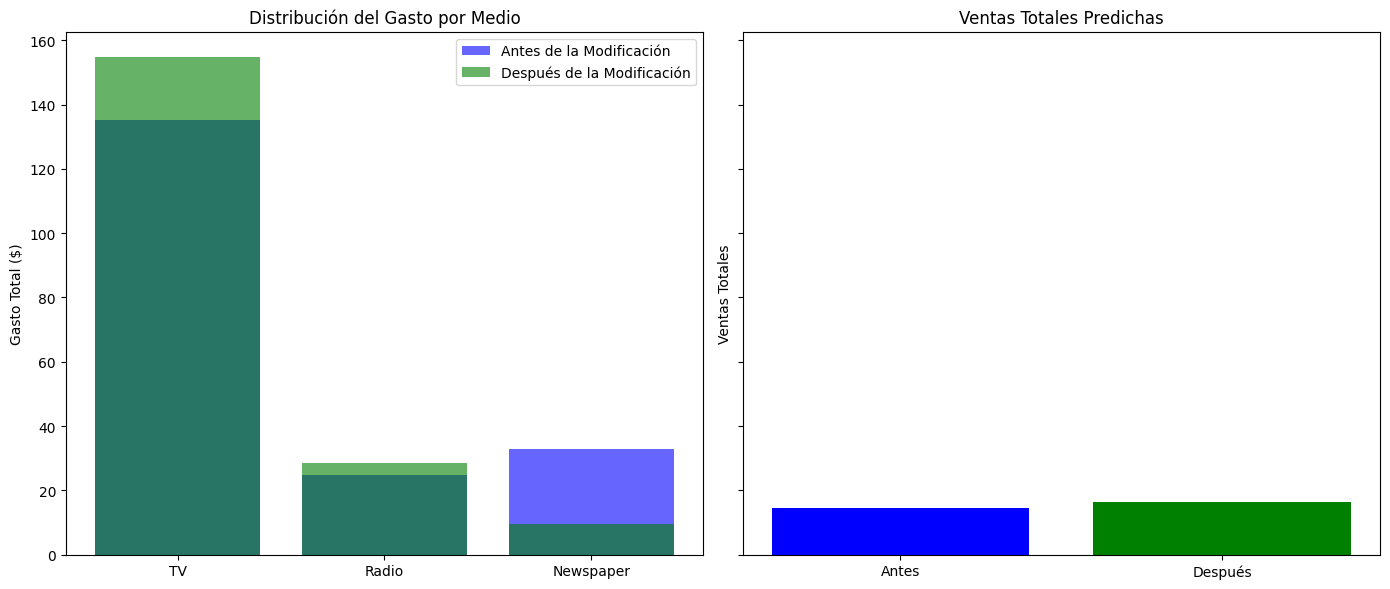

In [49]:
gasto_total_base = gasto_base.sum(axis=0)
gasto_total_ajustado = gasto_escenario_ajustado.sum(axis=0)

# Nombres de los medios para etiquetas
medios = ['TV', 'Radio', 'Newspaper']

# Crear la figura y los ejes
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Gráfico para la distribución del gasto
axs[0].bar(medios, gasto_total_base, label='Antes de la Modificación', alpha=0.6, color='blue')
axs[0].bar(medios, gasto_total_ajustado, label='Después de la Modificación', alpha=0.6, color='green')
axs[0].set_title('Distribución del Gasto por Medio')
axs[0].set_ylabel('Gasto Total ($)')
axs[0].legend()

# Gráfico para las ventas totales
ventas = [ventas_base[0], ventas_escenario_ajustado[0]]
escenarios = ['Antes', 'Después']
axs[1].bar(escenarios, ventas, color=['blue', 'green'])
axs[1].set_title('Ventas Totales Predichas')
axs[1].set_ylabel('Ventas Totales')

# Ajustes finales
plt.tight_layout()
plt.show()

#Escenario 3 :  reducimos a 0 el presupuesto en Newspaper y redistribuimos 70% y 30% en tv y Radio

In [22]:
nueva_distribucion = np.array([0.70, 0.30, 0.00])
gasto_total = gasto_base.sum()
nuevo_gasto = gasto_total * nueva_distribucion

# Predecir ventas para el nuevo escenario de gasto
ventas_escenario_nuevo = grid_search.best_estimator_.predict([nuevo_gasto])

# Mostrar los resultados
print(f"Ventas predichas con gasto base: {ventas_base[0]}")
print(f"Ventas predichas con el escenario ajustado: {ventas_escenario_nuevo[0]}")

# Calcular el cambio porcentual en las ventas
cambio_ventas = ((ventas_escenario_nuevo - ventas_base[0]) / ventas_base[0]) * 100
print(f"Cambio porcentual en las ventas con el escenario ajustado: {cambio_ventas[0]}%")

Ventas predichas con gasto base: 14.449000000000012
Ventas predichas con el escenario ajustado: 18.344000000000015
Cambio porcentual en las ventas con el escenario ajustado: 26.95688282926154%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


podemos ver que al hacer esto una subida del 26.95% se hace presente en las ventas

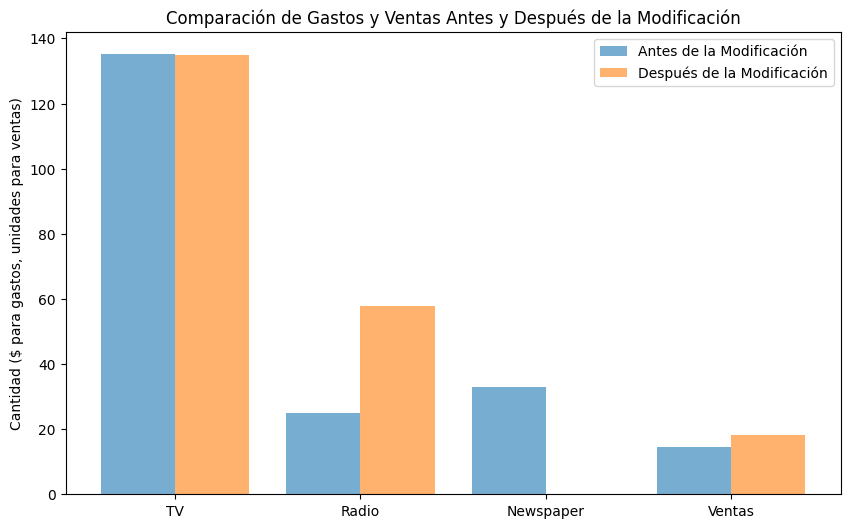

In [23]:
gastos_antes = gasto_base.sum(axis=0)  # Esto debería sumar los gastos originales por cada medio
ventas_antes = ventas_base[0]  # Ventas originales

# Datos para el escenario modificado
gastos_despues = nuevo_gasto
ventas_despues = ventas_escenario_nuevo[0]


medios = ['TV', 'Radio', 'Newspaper', 'Ventas']

# Calculamos los gastos totales y las ventas para añadirlos como 'barras' en nuestros gráficos
totales_antes = list(gastos_antes) + [ventas_antes]  # Añade ventas como una 'barra' más
totales_despues = list(gastos_despues) + [ventas_despues]  # Añade ventas modificadas

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Posiciones de las barras en el eje x
indice = range(len(medios))

# Barras para el escenario antes de la modificación
ax.bar(indice, totales_antes, width=0.4, label='Antes de la Modificación', align='center', alpha=0.6)

# Barras para el escenario después de la modificación (desplazamos ligeramente para no solapar)
ax.bar([p + 0.4 for p in indice], totales_despues, width=0.4, label='Después de la Modificación', align='center', alpha=0.6)

# Ajustar el eje x para mostrar las etiquetas correctamente
ax.set_xticks([p + 0.2 for p in indice])
ax.set_xticklabels(medios)

# Añadir títulos y etiquetas
ax.set_title('Comparación de Gastos y Ventas Antes y Después de la Modificación')
ax.set_ylabel('Cantidad ($ para gastos, unidades para ventas)')
ax.legend()

plt.show()




In [51]:
ventas_df = pd.DataFrame(ventas1)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


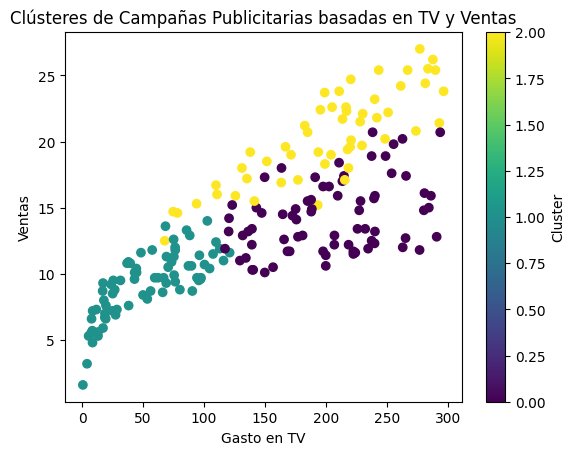

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


X = ventas_df[['TV', 'Radio', 'Newspaper', 'Sales']]

# Es buena práctica escalar los datos debido a que K-Means es sensible a las escalas de las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means. El número de clústeres (n_clusters) es un parámetro que puede requerir ajuste
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Etiquetamos de clúster para cada punto
clusters = kmeans.labels_

# Añadimos las etiquetas de clúster al DataFrame original para análisis
ventas1['Cluster'] = clusters

# Visualización de los clústeres (usando solo dos dimensiones, por simplicidad)
plt.scatter(ventas_df['TV'], ventas_df['Sales'], c=ventas1['Cluster'], cmap='viridis')
plt.xlabel('Gasto en TV')
plt.ylabel('Ventas')
plt.title('Clústeres de Campañas Publicitarias basadas en TV y Ventas')
plt.colorbar(label='Cluster')
plt.show()

guardamos los modelos

In [70]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(kmeans, 'modelo_kmeans.pkl')

['modelo_kmeans.pkl']

Text(0.5, 1.02, 'Pair Plot de Gastos de Publicidad y Ventas por Clúster')

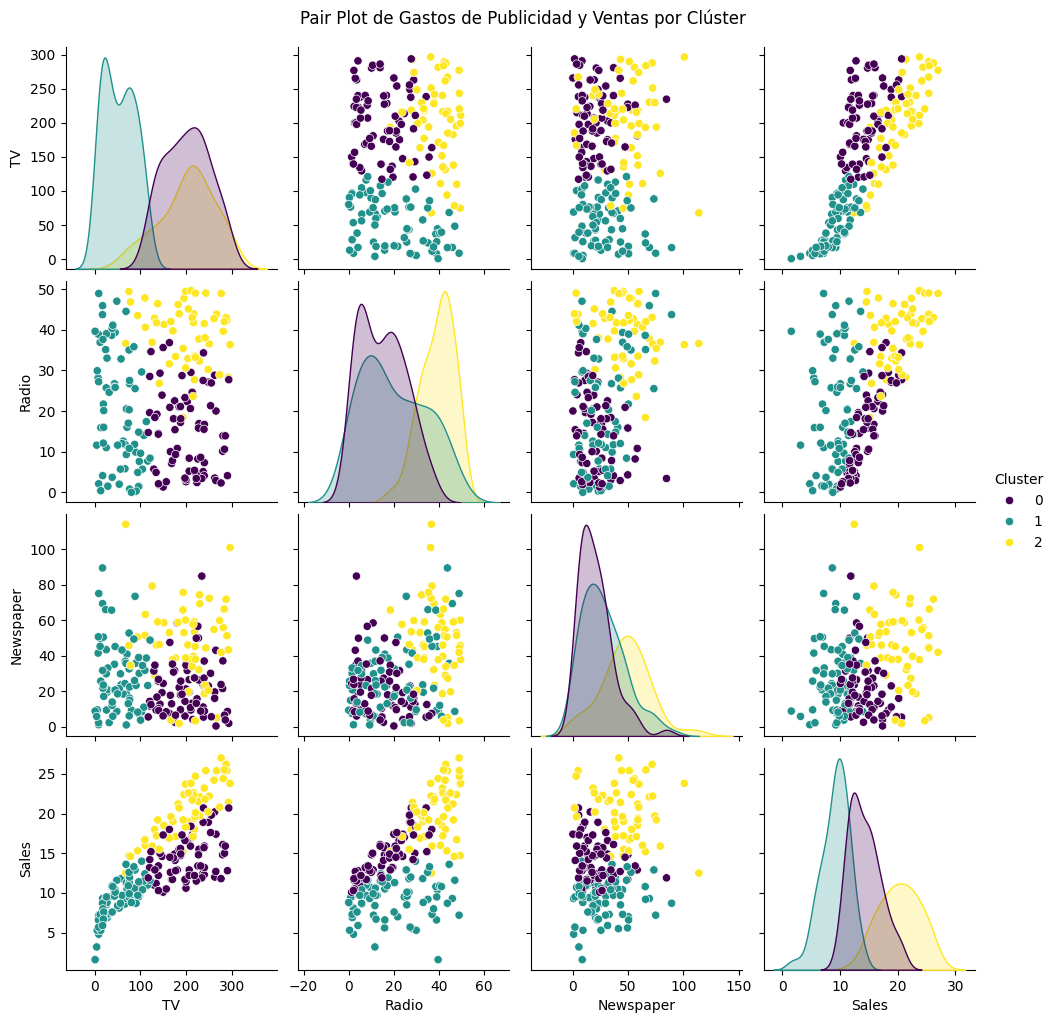

In [57]:
import seaborn as sns


# Creamos gráficos de pares con Seaborn
pair_plot = sns.pairplot(ventas1, vars=['TV', 'Radio', 'Newspaper', 'Sales'], hue='Cluster', palette='viridis')

pair_plot.fig.suptitle('Pair Plot de Gastos de Publicidad y Ventas por Clúster', y=1.02)  # Ajusta el título y su posición

In [60]:
ventas_df['Cluster'] = kmeans.labels_
ventas_df= ventas_df[['TV','Radio','Newspaper','Sales','Cluster']]

In [61]:
campañas_exitosas = ventas_df[ventas_df['Cluster'] == 2]
print(campañas_exitosas)

        TV  Radio  Newspaper  Sales  Cluster
0    230.1   37.8       69.2   22.1        2
3    151.5   41.3       58.5   18.5        2
14   204.1   32.9       46.0   19.0        2
15   195.4   47.7       52.9   22.4        2
16    67.8   36.6      114.0   12.5        2
17   281.4   39.6       55.8   24.4        2
20   218.4   27.7       53.4   18.0        2
30   292.9   28.3       43.2   21.4        2
36   266.9   43.8        5.0   25.4        2
37    74.7   49.4       45.7   14.7        2
39   228.0   37.7       32.0   21.5        2
41   177.0   33.4       38.7   17.1        2
47   239.9   41.5       18.5   23.2        2
52   216.4   41.7       39.6   22.6        2
53   182.6   46.2       58.7   21.2        2
55   198.9   49.4       60.0   23.7        2
58   210.8   49.6       37.7   23.8        2
61   261.3   42.7       54.7   24.2        2
64   131.1   42.8       28.9   18.0        2
69   216.8   43.9       27.2   22.3        2
70   199.1   30.6       38.7   18.3        2
84   213.5

In [71]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

model2 = LinearRegression()
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2}')

# Calculamos el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# Calculamos el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

R^2: 0.899438024100912
MSE: 3.1740973539761033
MAE: 1.4607567168117603


In [72]:
joblib.dump(model2, 'Regresion.pkl')

['Regresion.pkl']

In [63]:
gasto_tv_campaña_a = 180.1  # Gasto en TV de la primera campaña
gasto_radio_campaña_b = 159.6  # Gasto en Radio de la segunda campaña
gasto_newspaper_mantener = 9.2  # Supongamos que mantienes el gasto en Newspaper de la primera campaña

# Combinar los gastos en un nuevo array para hacer la predicción
gastos_combinados = [gasto_tv_campaña_a, gasto_radio_campaña_b, gasto_newspaper_mantener]


ventas_predichas = model.predict([gastos_combinados])

print(f"Ventas predichas para la combinación de gastos en TV de la Campaña A y Radio de la Campaña B: {ventas_predichas[0]}")

Ventas predichas para la combinación de gastos en TV de la Campaña A y Radio de la Campaña B: 41.25578634198551


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


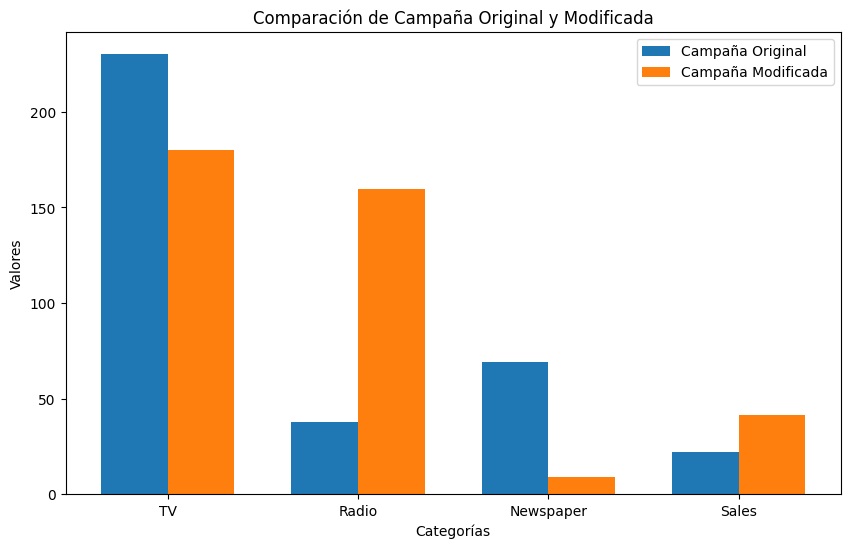

In [64]:
campaña_original = [230.1, 37.8, 69.2, 22.1]
campaña_modificada = [180.1, 159.6, 9.2, 41.25]

# Etiquetamos para los gráficos
categorias = ['TV', 'Radio', 'Newspaper', 'Sales']

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Establecemos la posición de las barras en el eje x
bar_width = 0.35
indices = range(len(campaña_original))

# Barras para la campaña original
ax.bar(indices, campaña_original, width=bar_width, label='Campaña Original')

# Barras para la campaña modificada (con un desplazamiento en el eje x)
ax.bar([i + bar_width for i in indices], campaña_modificada, width=bar_width, label='Campaña Modificada')

# Etiquetas y título
ax.set_xlabel('Categorías')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Campaña Original y Modificada')
ax.set_xticks([i + bar_width / 2 for i in indices])
ax.set_xticklabels(categorias)
ax.legend()

# Mostrar el gráfico
plt.show()

aqui podemos ver graficamente como mejoras las ventas si aumentamos el presupuesto en ciertas campañas como la de radio

# Conclusiones

podemos concluir que en terminos de ROI los medios de radio y newspaper tiene  un mayor rtorno , pero estos podria deberse a los menores costo que traen los mismos medios.

  Por otro lado pudimos ver que apartando el peso que puedan tener cada medio en las ventas por individual , hay una sinergia entre combinaciones de medios que influyen mas en las ventas , como por ejemplo la de tv con radio

  al mismo tiempo se plantearon varios escenarios posible conservando el mismo presupusto global en cada campaña pero redistribuyendo los gastos entre los medios y pudimos notar que al bajar los gastos signifivativamente en "newspaper" y subir los de radio hay un incremento en las ventas , pero el escenario mas prometedor  ocurre cuando se baja un poco el presupuesto de la tv y se equilibra con la radio sin necesidad de quitar el "newspaper" , esto sugiera que existe un punto en donde el medio TV deja de tener las mismas ganancia por el dinero invertido , y en este punto es donde tiene mas beneficio inventir el dinero en otro medio como por ejemplo la radio  